In [1]:
import torch
import ot
import math

import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from itertools import cycle
from tqdm.auto import trange
from mpl_toolkits import mplot3d
from scipy.stats import gaussian_kde
from typing import Any, Tuple, Optional
from torch import Tensor
#from geoopt.optim import RiemannianAdam
from copy import deepcopy

from hswfs.manifold.lorentz import Lorentz
from hswfs.manifold.poincare import Poincare

2023-09-26 09:24:21.836940: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-26 09:24:21.963791: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-26 09:24:24.195789: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-26 09:24:24.196195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-09-26 09:24:24.196226: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Ca

In [2]:
device = "cpu" # "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Utils Plot

In [3]:
manifold_lorentz = Lorentz(d=3)
manifold_poincare = Poincare(d=2)

In [4]:
## From https://colab.research.google.com/drive/1kSdmi2r6QMO7gI8YPqeiWoW2ayxcu1MY?usp=sharing#scrollTo=LFl3I-ycM0vJ

eps = 1e-7
max_clamp_norm = 40
max_norm = 85
ln_2: torch.Tensor = math.log(2)

radius = torch.Tensor([1.0]).to(device)


def expand_proj_dims(x: torch.Tensor) -> torch.Tensor:
    zeros = torch.zeros(x.shape[:-1] + torch.Size([1])).to(x.device).to(x.dtype)
    return torch.cat((zeros, x), dim=-1)

# We will use this clamping technique to ensure numerical stability of the Exp and Log maps
class LeakyClamp(torch.autograd.Function):
    @staticmethod
    def forward(ctx: Any, x: torch.Tensor, min: float, max: float) -> torch.Tensor:
        ctx.save_for_backward(x.ge(min) * x.le(max))
        return torch.clamp(x, min=min, max=max)

    @staticmethod
    def backward(ctx: Any, grad_output: torch.Tensor) -> Tuple[torch.Tensor, None, None]:
        mask, = ctx.saved_tensors
        mask = mask.type_as(grad_output)
        return grad_output * mask + grad_output * (1 - mask) * eps, None, None

def clamp(x: torch.Tensor, min: float = float("-inf"), max: float = float("+inf")) -> torch.Tensor:
    return LeakyClamp.apply(x, min, max)

def cosh(x: torch.Tensor) -> torch.Tensor:
    x = clamp(x, min=-max_norm, max=max_norm)
    return torch.cosh(x)

def sinh(x: torch.Tensor) -> torch.Tensor:
    x = clamp(x, min=-max_norm, max=max_norm)
    return torch.sinh(x)

# Exp map for the origin has a special form which doesn't need the Lorentz norm
def exp_map_mu0(x: Tensor, radius: Tensor) -> Tensor:
    assert x[..., 0].allclose(torch.zeros_like(x[..., 0]))
    x = x[..., 1:]
    x_norm = torch.norm(x, p=2, keepdim=True, dim=-1) / radius
    x_normed = F.normalize(x, p=2, dim=-1) * radius
    ret = torch.cat((cosh(x_norm) * radius, sinh(x_norm) * x_normed), dim=-1)
    assert torch.isfinite(ret).all()
    return ret

# Helper function to do the plotting
def plot_density(xy_poincare, probs, radius, mu=None, ax=None, cmap="Oranges"):
    axis_lim = 1.01
    
    if ax is None:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)

    x = xy_poincare[:, 0].view(-1, 100).detach().cpu()
    y = xy_poincare[:, 1].view(-1, 100).detach().cpu()
    z = probs.view(-1, 100).detach().cpu()
    range_lim = 2
    # Define points within circle
    if mu is not None:
        mu = mu.cpu().numpy()
        plt.plot(mu[:, 0], mu[:, 1], 'b+')

    cnt = ax.contourf(x, y, z, 100, antialiased=False, cmap=cmap)
    
    ## Remove aliasing from pdf rendering (https://stackoverflow.com/questions/15822159/aliasing-when-saving-matplotlib-filled-contour-plot-to-pdf-or-eps)
    for c in cnt.collections:
        c.set_edgecolor("face")
    ax.axis('off')

    # draw some fancy circle
    circle = plt.Circle((0, 0), 1, color='k', linewidth=2, fill=False)
    ax.add_patch(circle)
    # Makes the circle look like a circle
    ax.axis('equal')
    ax.set_xlim(-axis_lim, axis_lim)
    ax.set_ylim(-axis_lim, axis_lim)

In [5]:
# def plot_distrib(X, ax, h=None):
#     kernel = gaussian_kde(X.detach().cpu().numpy().T)
    
#     if h is not None:
#         kernel.set_bandwidth(h)

#     # Map x, y coordinates on tangent space at origin to manifold (Lorentz model).
#     x = np.arange(-5, 5, 0.1)
#     y = np.arange(-5, 5, 0.1)
#     x, y = np.meshgrid(x, y)
#     x = torch.Tensor(x).view(-1, 1)
#     y = torch.Tensor(y).view(-1, 1)
#     twodim = torch.cat([x, y], dim=1)
#     threedim = expand_proj_dims(twodim)
#     clamped_threedim = clamp(threedim, min=-max_clamp_norm,
#           max=max_clamp_norm).to(device)

#     on_mani = exp_map_mu0(clamped_threedim, radius)
#     probs = torch.tensor(kernel.pdf(on_mani.T.detach().cpu().numpy()))
#     # Calculate the poincare coordinates
#     xy_poincare = lorentz_to_poincare(on_mani.squeeze(), radius)
#     plot_density(xy_poincare, probs, radius,ax=ax)
    
    
    
    
def minkowski_kernel_density(grid, X, sig, weight=None):
    if weight is None:
        weight = torch.ones((X.shape[0]), dtype=torch.float64) / X.shape[0]
        
    kernel = manifold_lorentz.minkowski_ip2(grid, X)
#     kernel = torch.arccosh(-kernel)
    kernel = torch.arccosh(torch.clamp(-kernel, min=1+1e-5))
    kernel = (-kernel / sig).exp()
    kernel = torch.matmul(kernel.T, weight)
    return kernel

    
def plot_distrib(X, ax, weights=None, sig=0.2, cmap='Oranges'):
    """
        X must be on the Lorentz model
    """

    # Map x, y coordinates on tangent space at origin to manifold (Lorentz model).
    x = np.arange(-5, 5, 0.1)
    y = np.arange(-5, 5, 0.1)
    x, y = np.meshgrid(x, y)
    x = torch.Tensor(x).view(-1, 1)
    y = torch.Tensor(y).view(-1, 1)
    twodim = torch.cat([x, y], dim=1)
    threedim = expand_proj_dims(twodim)
    clamped_threedim = clamp(threedim, min=-max_clamp_norm, max=max_clamp_norm).to(device)

    on_mani = exp_map_mu0(clamped_threedim, radius)
    on_mani_poincare = manifold_lorentz.to_poincare(on_mani)
    
    probs = minkowski_kernel_density(on_mani, X, weight=weights, sig=sig)
    # Calculate the poincare coordinates
    xy_poincare = manifold_lorentz.to_poincare(on_mani.squeeze())
    plot_density(xy_poincare, probs, radius,ax=ax, cmap=cmap)

In [6]:
def plot_fig(X_target, L_ghsw, L_hhsw, L_sw, L_hhswp, ax0, ax1, h=None):
    L_ghsw10 = np.log10(L_ghsw)
    L_hhsw10 = np.log10(L_hhsw)
    L_sw10 = np.log10(L_sw)
    L_swp10 = np.log10(L_hhswp)

    mean_ghsw = np.mean(L_ghsw10, axis=0)
    std_ghsw = np.std(L_ghsw10, axis=0)

    mean_hhsw = np.mean(L_hhsw10, axis=0)
    std_hhsw = np.std(L_hhsw10, axis=0)

    mean_sw = np.mean(L_sw10, axis=0)
    std_sw = np.std(L_sw10, axis=0)

    mean_hhswp = np.mean(L_hhswp10, axis=0)
    std_hhswp = np.std(L_hhswp10, axis=0)

    n_epochs = len(mean_hhsw)
    iterations = range(n_epochs)
    
    
#     fig, ax = plt.subplots(1, 2, figsize=(9,2), gridspec_kw={"width_ratios":[1,2]})

    plot_distrib(X_target, ax0) #, h)

    ax1.plot(iterations, mean_ghsw, label="GHSW")
    ax1.fill_between(iterations, mean_ghsw-std_ghsw, mean_ghsw+std_ghsw, alpha=0.5)
    ax1.plot(iterations, mean_hhsw, label="HHSW")
    ax1.fill_between(iterations, mean_hhsw-std_hhsw, mean_hhsw+std_hhsw, alpha=0.5)
    ax1.plot(iterations, mean_sw, label="SW on Poincaré")
    ax1.fill_between(iterations, mean_sw-std_sw, mean_sw+std_sw, alpha=0.5)
#     ax1.plot(iterations, mean_hhswp, label="HHSW on Poincaré")
#     ax1.fill_between(iterations, mean_hhswp-std_hhswp, mean_hhswp+std_hhswp, alpha=0.5)

    ax1.set_xlabel("Iterations", fontsize=13)
    ax1.set_ylabel(r"$\log_{10}(W_2^2(\hat{\mu}_n,\nu))$", fontsize=13)
    ax1.grid(True)
    # ax[1].set_yticks([1,0.5,0,-0.5,-1])
    ax1.legend()

    # plt.savefig("./Comparison_Evolution_WND_Target_border.pdf", format="pdf", bbox_inches="tight")
#     plt.show()

### WND Center

In [7]:
mu = torch.tensor([1.5, np.sqrt(1.5**2-1), 0], dtype=torch.float64, device=device)
Sigma = 0.1 * torch.tensor([[1,0],[0,1]], dtype=torch.float, device=device)
X_target_wnd_c = manifold_lorentz.sample_wrapped_normal(10000, mu, Sigma)

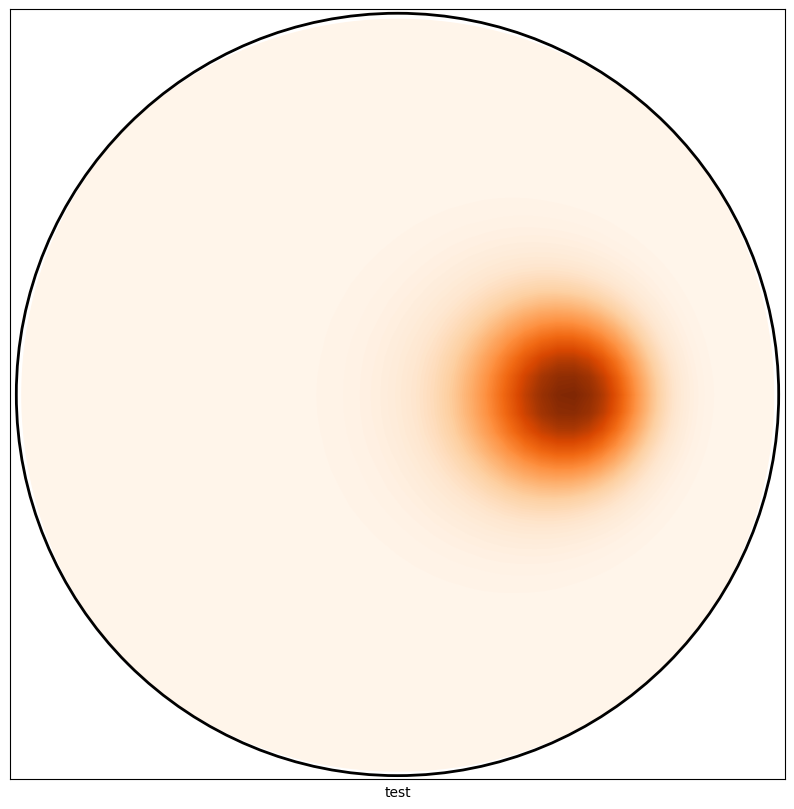

In [8]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
plot_distrib(X_target_wnd_c, ax)
ax.set_xlabel('test')
ax.axis('on')
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [9]:
L_sw_wnd_c = np.loadtxt("./Results/sw_loss_wnd_center")
L_hhsw_wnd_c = np.loadtxt("./Results/hhsw_loss_wnd_center")
L_ghsw_wnd_c = np.loadtxt("./Results/ghsw_loss_wnd_center")
L_hhswp_wnd_c = np.loadtxt("./Results/hhswp_loss_wnd_center")


L_sw10 = np.log10(L_sw_wnd_c)
L_hhsw10 = np.log10(L_hhsw_wnd_c)
L_ghsw10 = np.log10(L_ghsw_wnd_c)
L_hhswp10 = np.log10(L_hhswp_wnd_c)

mean_sw = np.mean(L_sw10, axis=0)
std_sw = np.std(L_sw10, axis=0)

mean_hhsw = np.mean(L_hhsw10, axis=0)
std_hhsw = np.std(L_hhsw10, axis=0)

mean_ghsw = np.mean(L_ghsw10, axis=0)
std_ghsw = np.std(L_ghsw10, axis=0)

mean_hhswp = np.mean(L_hhswp10, axis=0)
std_hhswp = np.std(L_hhswp10, axis=0)

n_epochs = len(mean_hhsw)
iterations = range(n_epochs)

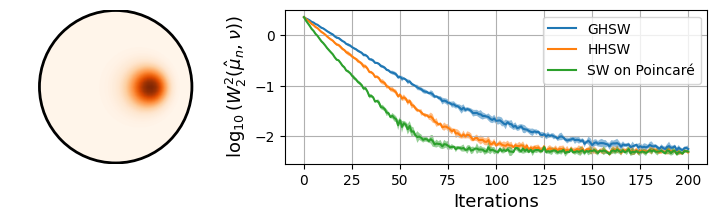

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(9,2), gridspec_kw={"width_ratios":[1,2]})

plot_distrib(X_target_wnd_c, ax[0])

ax[1].plot(iterations, mean_ghsw, label="GHSW")
ax[1].fill_between(iterations, mean_ghsw-std_ghsw, mean_ghsw+std_ghsw, alpha=0.5)
ax[1].plot(iterations, mean_hhsw, label="HHSW")
ax[1].fill_between(iterations, mean_hhsw-std_hhsw, mean_hhsw+std_hhsw, alpha=0.5)
ax[1].plot(iterations, mean_sw, label="SW on Poincaré")
ax[1].fill_between(iterations, mean_sw-std_sw, mean_sw+std_sw, alpha=0.5)
# ax[1].plot(iterations, mean_swl, label="SW on Lorentz")
# ax[1].fill_between(iterations, mean_swl-std_swl, mean_swl+std_swl, alpha=0.5)
# ax[1].plot(iterations, mean_hhswp, label="HHSW on Poincaré")
# ax[1].fill_between(iterations, mean_hhswp-std_hhswp, mean_hhswp+std_hhswp, alpha=0.5)

ax[1].set_xlabel("Iterations", fontsize=13)
ax[1].set_ylabel(r"$\log_{10}(W_2^2(\hat{\mu}_n,\nu))$", fontsize=13)
ax[1].grid(True)
# ax[1].set_yticks([1,0.5,0,-0.5,-1])
ax[1].legend()

# plt.savefig("./Comparison_Evolution_WND_Target_center.pdf", format="pdf", bbox_inches="tight")
plt.show()

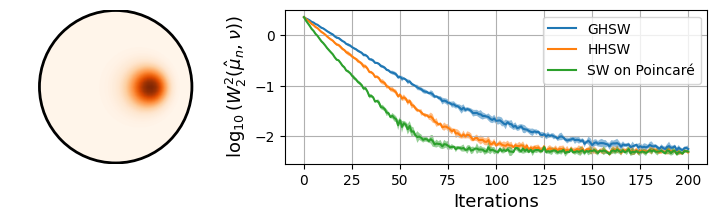

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(9,2), gridspec_kw={"width_ratios":[1,2]})

plot_fig(X_target_wnd_c, L_ghsw_wnd_c, L_hhsw_wnd_c, L_sw_wnd_c, L_hhswp_wnd_c, ax[0], ax[1])
plt.show()

### WND Border

In [12]:
mu = torch.tensor([8, np.sqrt(63), 0], dtype=torch.float64, device=device)
Sigma = 0.1 * torch.tensor([[1,0],[0,1]], dtype=torch.float, device=device)
X_target_wnd_b = manifold_lorentz.sample_wrapped_normal(10000, mu, Sigma)

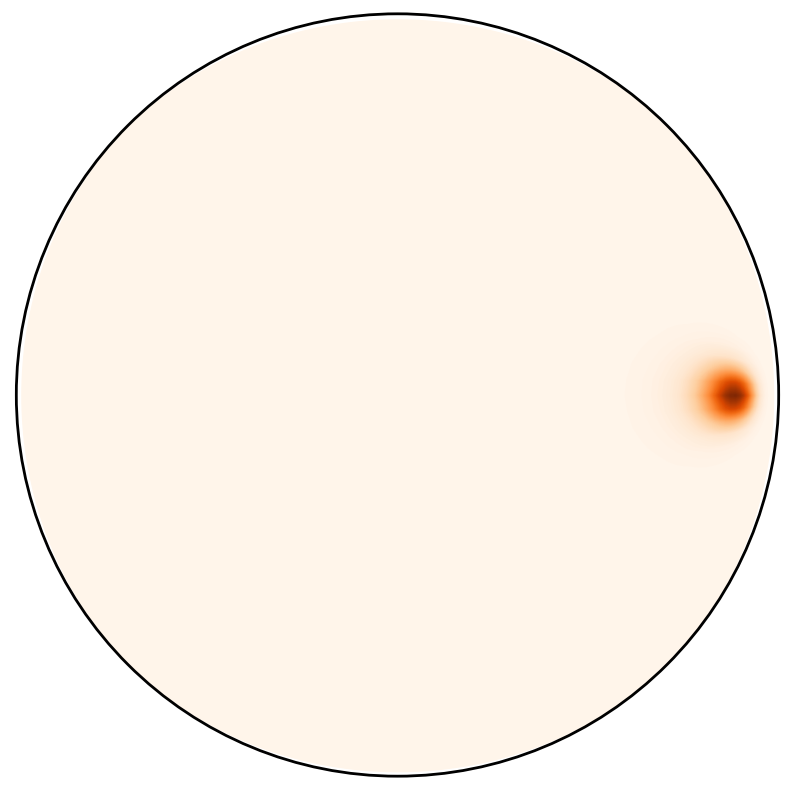

In [13]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
plot_distrib(X_target_wnd_b, ax)
plt.show()

In [14]:
L_ghsw_wnd_b = np.loadtxt("./Results/ghsw_loss_wnd_border")
L_hhsw_wnd_b = np.loadtxt("./Results/hhsw_loss_wnd_border")
L_sw_wnd_b = np.loadtxt("./Results/sw_loss_wnd_border")
L_hhswp_wnd_b = np.loadtxt("./Results/hhswp_loss_wnd_border")


L_ghsw10 = np.log10(L_ghsw_wnd_b)
L_hhsw10 = np.log10(L_hhsw_wnd_b)
L_sw10 = np.log10(L_sw_wnd_b)
L_hhswp10 = np.log10(L_hhswp_wnd_b)

mean_ghsw = np.mean(L_ghsw10, axis=0)
std_ghsw = np.std(L_ghsw10, axis=0)

mean_hhsw = np.mean(L_hhsw10, axis=0)
std_hhsw = np.std(L_hhsw10, axis=0)

mean_sw = np.mean(L_sw10, axis=0)
std_sw = np.std(L_sw10, axis=0)

mean_hhswp = np.mean(L_hhswp10, axis=0)
std_hhswp = np.std(L_hhswp10, axis=0)

n_epochs = len(mean_hhsw)
iterations = range(n_epochs)

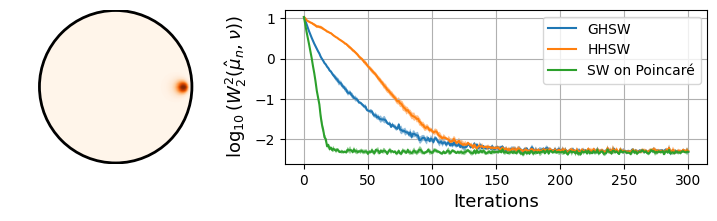

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(9,2), gridspec_kw={"width_ratios":[1,2]})

plot_distrib(X_target_wnd_b, ax[0])

ax[1].plot(iterations, mean_ghsw, label="GHSW")
ax[1].fill_between(iterations, mean_ghsw-std_ghsw, mean_ghsw+std_ghsw, alpha=0.5)
ax[1].plot(iterations, mean_hhsw, label="HHSW")
ax[1].fill_between(iterations, mean_hhsw-std_hhsw, mean_hhsw+std_hhsw, alpha=0.5)
ax[1].plot(iterations, mean_sw, label="SW on Poincaré")
ax[1].fill_between(iterations, mean_sw-std_sw, mean_sw+std_sw, alpha=0.5)
# ax[1].plot(iterations, mean_hhswp, label="HHSW on Poincaré")
# ax[1].fill_between(iterations, mean_hhswp-std_hhswp, mean_hhswp+std_hhswp, alpha=0.5)

ax[1].set_xlabel("Iterations", fontsize=13)
ax[1].set_ylabel(r"$\log_{10}(W_2^2(\hat{\mu}_n,\nu))$", fontsize=13)
ax[1].grid(True)
# ax[1].set_yticks([1,0.5,0,-0.5,-1])
ax[1].legend()

# plt.savefig("./Comparison_Evolution_WND_Target_border.pdf", format="pdf", bbox_inches="tight")
plt.show()

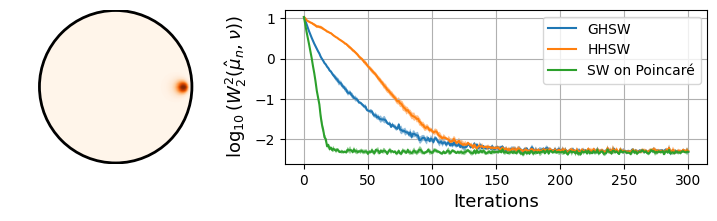

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(9,2), gridspec_kw={"width_ratios":[1,2]})

plot_fig(X_target_wnd_b, L_ghsw_wnd_b, L_hhsw_wnd_b, L_sw_wnd_b, L_hhswp_wnd_b, ax[0], ax[1])
plt.show()

### MWND Center

In [17]:
ps = np.ones(5)/5
mus_lorentz = torch.tensor([[0,0.5],[0.5,0],[0,-0.5],[-0.5,0], [0,0.1]], dtype=torch.float)
mus = manifold_poincare.to_lorentz(mus_lorentz)
sigma = 0.01 * torch.tensor([[1,0],[0,1]], dtype=torch.float)

Z = np.random.multinomial(10000, ps)
X = []
for l in range(len(Z)):
    if Z[l]>0:
        samples = manifold_lorentz.sample_wrapped_normal(int(Z[l]), mus[l], sigma).numpy()
        X += list(samples)

X_target_mwnd_c = torch.tensor(X, device=device, dtype=torch.float64)

/tmp/ipykernel_22737/2451082059.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  X_target_mwnd_c = torch.tensor(X, device=device, dtype=torch.float64)


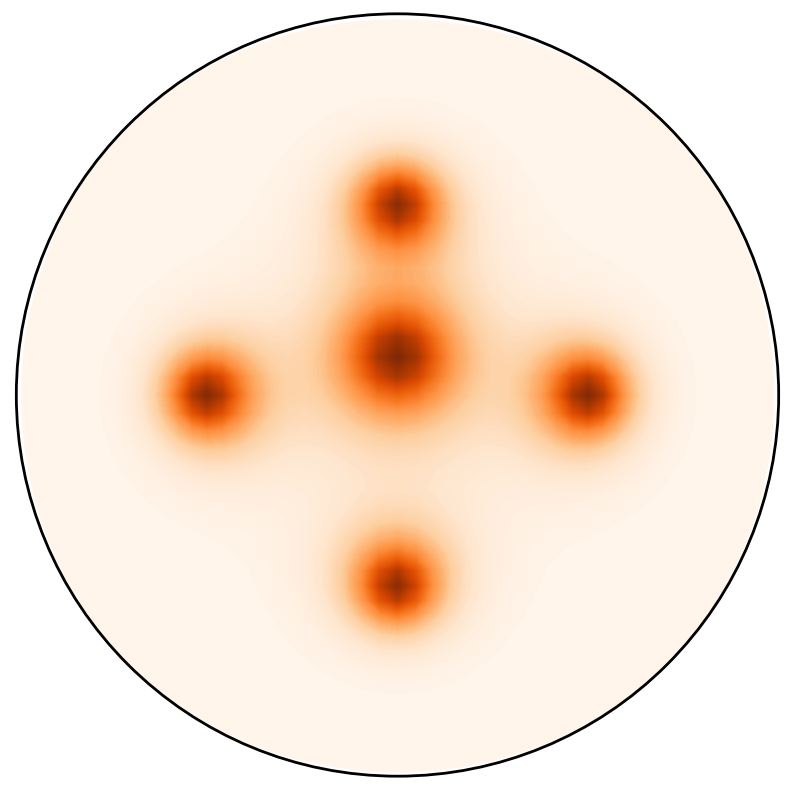

In [18]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
plot_distrib(X_target_mwnd_c, ax)
plt.show()

In [19]:
L_ghsw_mwnd_c = np.loadtxt("./Results/ghsw_loss_mwnd_center")
L_hhsw_mwnd_c = np.loadtxt("./Results/hhsw_loss_mwnd_center")
L_sw_mwnd_c = np.loadtxt("./Results/sw_loss_mwnd_center")
L_hhswp_mwnd_c = np.loadtxt("./Results/hhswp_loss_mwnd_center")


L_ghsw10 = np.log10(L_ghsw_mwnd_c)
L_hhsw10 = np.log10(L_hhsw_mwnd_c)
L_sw10 = np.log10(L_sw_mwnd_c)
L_hhswp10 = np.log10(L_hhswp_mwnd_c)

mean_ghsw = np.mean(L_ghsw10, axis=0)
std_ghsw = np.std(L_ghsw10, axis=0)

mean_hhsw = np.mean(L_hhsw10, axis=0)
std_hhsw = np.std(L_hhsw10, axis=0)

mean_sw = np.mean(L_sw10, axis=0)
std_sw = np.std(L_sw10, axis=0)

mean_hhswp = np.mean(L_hhswp10, axis=0)
std_hhswp = np.std(L_hhswp10, axis=0)

n_epochs = len(mean_hhsw)
iterations = range(n_epochs)

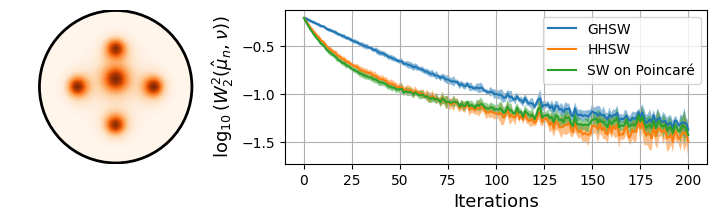

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(9,2), gridspec_kw={"width_ratios":[1,2]})

plot_distrib(X_target_mwnd_c, ax[0])

ax[1].plot(iterations, mean_ghsw, label="GHSW")
ax[1].fill_between(iterations, mean_ghsw-std_ghsw, mean_ghsw+std_ghsw, alpha=0.5)
ax[1].plot(iterations, mean_hhsw, label="HHSW")
ax[1].fill_between(iterations, mean_hhsw-std_hhsw, mean_hhsw+std_hhsw, alpha=0.5)
ax[1].plot(iterations, mean_sw, label="SW on Poincaré")
ax[1].fill_between(iterations, mean_sw-std_sw, mean_sw+std_sw, alpha=0.5)
# ax[1].plot(iterations, mean_hhswp, label="HHSW on Poincaré")
# ax[1].fill_between(iterations, mean_hhswp-std_hhswp, mean_hhswp+std_hhswp, alpha=0.5)

ax[1].set_xlabel("Iterations", fontsize=13)
ax[1].set_ylabel(r"$\log_{10}(W_2^2(\hat{\mu}_n,\nu))$", fontsize=13)
ax[1].grid(True)
# ax[1].set_yticks([1,0.5,0,-0.5,-1])
ax[1].legend()

# plt.savefig("./Comparison_Evolution_MWND_Target_center.pdf", format="pdf", bbox_inches="tight")
plt.show()

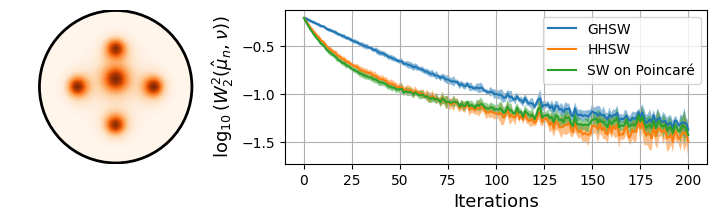

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(9,2), gridspec_kw={"width_ratios":[1,2]})

plot_fig(X_target_mwnd_c, L_ghsw_mwnd_c, L_hhsw_mwnd_c, L_sw_mwnd_c, L_hhswp_mwnd_c, ax[0], ax[1])
plt.show()

### MWND Border

In [22]:
ps = np.ones(5)/5
mus_lorentz = torch.tensor([[0,0.9],[0.9,0],[0,-0.9],[-0.9,0], [0,0.1]], dtype=torch.float)
mus = manifold_poincare.to_lorentz(mus_lorentz)
sigma = 0.01 * torch.tensor([[1,0],[0,1]], dtype=torch.float)

Z = np.random.multinomial(10000, ps)
X = []
for l in range(len(Z)):
    if Z[l]>0:
        samples = manifold_lorentz.sample_wrapped_normal(int(Z[l]), mus[l], sigma).numpy()
        X += list(samples)

X_target_mwnd_b = torch.tensor(X, device=device, dtype=torch.float64)

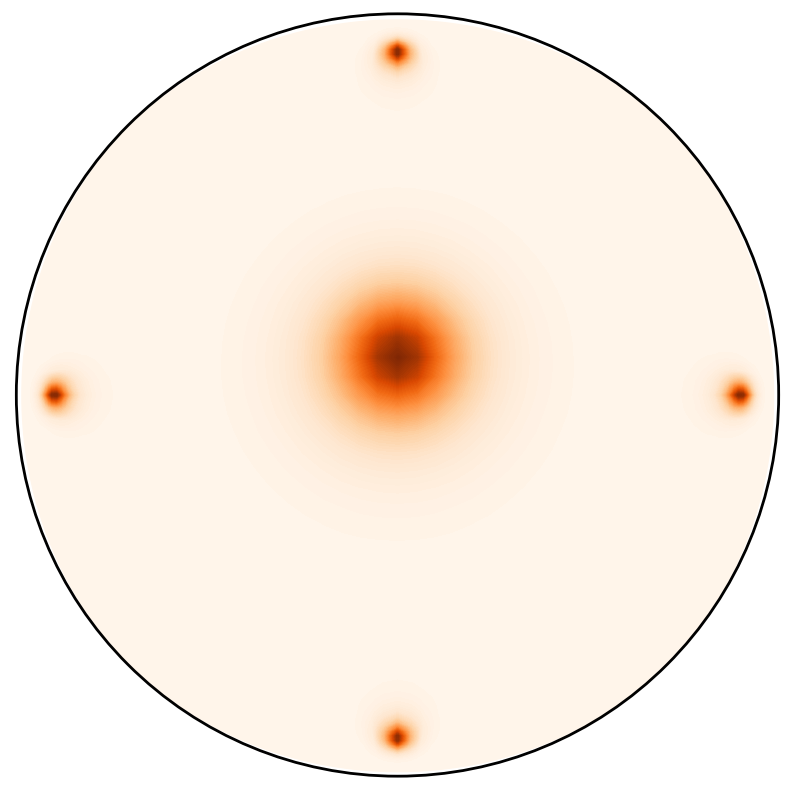

In [23]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
plot_distrib(X_target_mwnd_b, ax)
plt.show()

In [24]:
L_ghsw_mwnd_b = np.loadtxt("./Results/ghsw_loss_mwnd_border")
L_hhsw_mwnd_b = np.loadtxt("./Results/hhsw_loss_mwnd_border")
L_sw_mwnd_b = np.loadtxt("./Results/sw_loss_mwnd_border")
L_hhswp_mwnd_b = np.loadtxt("./Results/hhswp_loss_mwnd_border")


L_ghsw10 = np.log10(L_ghsw_mwnd_b)
L_hhsw10 = np.log10(L_hhsw_mwnd_b)
L_sw10 = np.log10(L_sw_mwnd_b)
L_hhswp10 = np.log10(L_hhswp_mwnd_b)

mean_ghsw = np.mean(L_ghsw10, axis=0)
std_ghsw = np.std(L_ghsw10, axis=0)

mean_hhsw = np.mean(L_hhsw10, axis=0)
std_hhsw = np.std(L_hhsw10, axis=0)

mean_sw = np.mean(L_sw10, axis=0)
std_sw = np.std(L_sw10, axis=0)

mean_hhswp = np.mean(L_hhswp10, axis=0)
std_hhswp = np.std(L_hhswp10, axis=0)

n_epochs = len(mean_hhsw)
iterations = range(n_epochs)

/tmp/ipykernel_22737/2317646161.py:8: RuntimeWarning: divide by zero encountered in log10
  L_hhsw10 = np.log10(L_hhsw_mwnd_b)
/home/clement/anaconda3/envs/geomstats/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


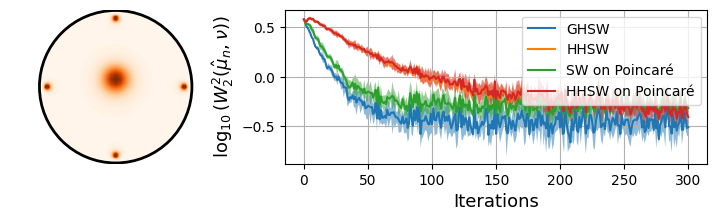

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(9,2), gridspec_kw={"width_ratios":[1,2]})

plot_distrib(X_target_mwnd_b, ax[0]) #, h=0.1)

ax[1].plot(iterations, mean_ghsw, label="GHSW")
ax[1].fill_between(iterations, mean_ghsw-std_ghsw, mean_ghsw+std_ghsw, alpha=0.5)
ax[1].plot(iterations, mean_hhsw, label="HHSW")
ax[1].fill_between(iterations, mean_hhsw-std_hhsw, mean_hhsw+std_hhsw, alpha=0.5)
ax[1].plot(iterations, mean_sw, label="SW on Poincaré")
ax[1].fill_between(iterations, mean_sw-std_sw, mean_sw+std_sw, alpha=0.5)
ax[1].plot(iterations, mean_hhswp, label="HHSW on Poincaré")
ax[1].fill_between(iterations, mean_hhswp-std_hhswp, mean_hhswp+std_hhswp, alpha=0.5)

ax[1].set_xlabel("Iterations", fontsize=13)
ax[1].set_ylabel(r"$\log_{10}(W_2^2(\hat{\mu}_n,\nu))$", fontsize=13)
ax[1].grid(True)
# ax[1].set_yticks([1,0.5,0,-0.5,-1])
ax[1].legend()

# plt.savefig("./Comparison_Evolution_MWND_Target_border.pdf", format="pdf", bbox_inches="tight")
plt.show()

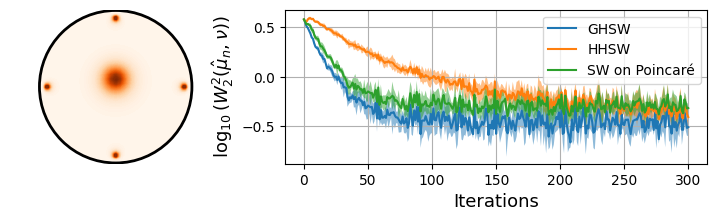

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(9,2), gridspec_kw={"width_ratios":[1,2]})

plot_fig(X_target_mwnd_b, L_ghsw_mwnd_b, L_hhswp_mwnd_b, L_sw_mwnd_b, L_hhswp_mwnd_b, ax[0], ax[1], h=0.1)
plt.show()

### Figure

In [27]:
def plot_fig(X_target, L_ghsw, L_hhsw, L_sw, L_hhswp, ax0, ax1, h=None, 
             xlabels=True, ylabels=True, xticks=True, yticks=True, 
             title=False, legend=False, ax0_legend=False, alpha=0.1):
    
    L_ghsw10 = np.log10(L_ghsw)
    L_hhsw10 = np.log10(L_hhsw)
    L_sw10 = np.log10(L_sw)
    L_hhswp10 = np.log10(L_hhswp)

    mean_ghsw = np.mean(L_ghsw10, axis=0)
    std_ghsw = np.std(L_ghsw10, axis=0)

    mean_hhsw = np.mean(L_hhsw10, axis=0)
    std_hhsw = np.std(L_hhsw10, axis=0)

    mean_sw = np.mean(L_sw10, axis=0)
    std_sw = np.std(L_sw10, axis=0)

    mean_hhswp = np.mean(L_hhswp10, axis=0)
    std_hhswp = np.std(L_hhswp10, axis=0)
    

    n_epochs = len(mean_hhsw)
    iterations = range(n_epochs)
    
    
#     fig, ax = plt.subplots(1, 2, figsize=(9,2), gridspec_kw={"width_ratios":[1,2]})

    plot_distrib(X_target, ax0) #, h)
    if ax0_legend:
        ax0.set_title(r"Target distributions", va='bottom', fontsize=13)
        
    ax1.plot(iterations, mean_ghsw, label="GHSW", alpha=1)
    ax1.fill_between(iterations, mean_ghsw-std_ghsw, mean_ghsw+std_ghsw, alpha=alpha)
    ax1.plot(iterations, mean_hhsw, label="HHSW", alpha=1)
    ax1.fill_between(iterations, mean_hhsw-std_hhsw, mean_hhsw+std_hhsw, alpha=alpha)
    ax1.plot(iterations, mean_sw, label="SW on Poincaré", alpha=1)
    ax1.fill_between(iterations, mean_sw-std_sw, mean_sw+std_sw, alpha=alpha)
#     ax1.plot(iterations, mean_hhswp, label="HHSW on Poincaré", alpha=1)
#     ax1.fill_between(iterations, mean_hhswp-std_hhswp, mean_hhswp+std_hhswp, alpha=0.1)
    
    if xlabels:
        ax1.set_xlabel("Iterations", fontsize=13)
        
#     if ylabels:
    if title:
        ax1.set_title(r"$\log_{10}(W_2^2(\hat{\mu}_n,\nu))$", fontsize=13)
        
    ax1.grid(True)
    # ax[1].set_yticks([1,0.5,0,-0.5,-1])
    
    if not xticks:
        ax1.xaxis.set_ticklabels([])
#         ax1.set_xticks([])
    if legend:
        ax1.legend()

    # plt.savefig("./Comparison_Evolution_WND_Target_border.pdf", format="pdf", bbox_inches="tight")
#     plt.show()

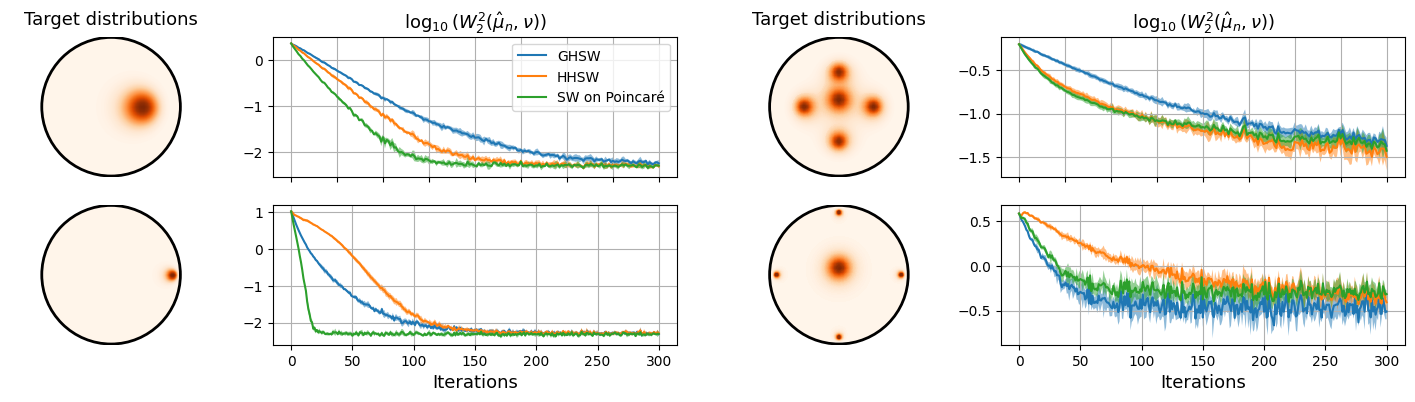

In [28]:
fig, ax = plt.subplots(2, 4, figsize=(18,4), gridspec_kw={"width_ratios":[1,2,1,2]})

plot_fig(X_target_wnd_c, L_ghsw_wnd_c, L_hhsw_wnd_c, L_sw_wnd_c, L_hhswp_wnd_c, ax[0,0], ax[0,1], 
         xticks=False, xlabels=False, title=True, alpha=0.5, legend=True, ax0_legend=True)
plot_fig(X_target_wnd_b, L_ghsw_wnd_b, L_hhsw_wnd_b, L_sw_wnd_b, L_hhswp_wnd_b, ax[1,0], ax[1,1], alpha=0.5)
plot_fig(X_target_mwnd_c, L_ghsw_mwnd_c, L_hhsw_mwnd_c, L_sw_mwnd_c, L_hhswp_mwnd_c, ax[0,2], ax[0,3], 
         xticks=False, xlabels=False, title=True, alpha=0.5, ax0_legend=True)
plot_fig(X_target_mwnd_b, L_ghsw_mwnd_b, L_hhswp_mwnd_b, L_sw_mwnd_b, L_hhswp_mwnd_b, ax[1,2], ax[1,3], h=0.1, alpha=0.5)

# plt.savefig("./Comparison_Evolution_HSWFs.pdf", format="pdf", bbox_inches="tight")

plt.show()

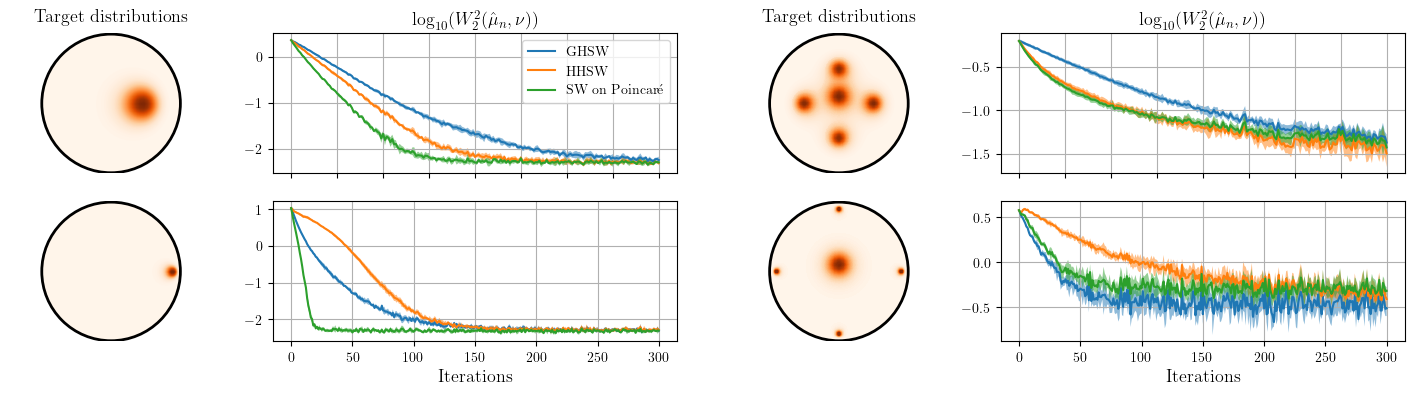

In [29]:
import matplotlib.font_manager

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "cm"
})

fig, ax = plt.subplots(2, 4, figsize=(18,4), gridspec_kw={"width_ratios":[1,2,1,2]})

plot_fig(X_target_wnd_c, L_ghsw_wnd_c, L_hhsw_wnd_c, L_sw_wnd_c, L_hhswp_wnd_c, ax[0,0], ax[0,1], 
         xticks=False, xlabels=False, title=True, alpha=0.5, legend=True, ax0_legend=True)
plot_fig(X_target_wnd_b, L_ghsw_wnd_b, L_hhsw_wnd_b, L_sw_wnd_b, L_hhswp_wnd_b, ax[1,0], ax[1,1], alpha=0.5)
plot_fig(X_target_mwnd_c, L_ghsw_mwnd_c, L_hhsw_mwnd_c, L_sw_mwnd_c, L_hhswp_mwnd_c, ax[0,2], ax[0,3], 
         xticks=False, xlabels=False, title=True, alpha=0.5, ax0_legend=True)
plot_fig(X_target_mwnd_b, L_ghsw_mwnd_b, L_hhswp_mwnd_b, L_sw_mwnd_b, L_hhswp_mwnd_b, ax[1,2], ax[1,3], h=0.1, alpha=0.5)

# plt.savefig("./Comparison_Evolution_HSWFs_LateX.pdf", format="pdf", bbox_inches="tight")

plt.show()

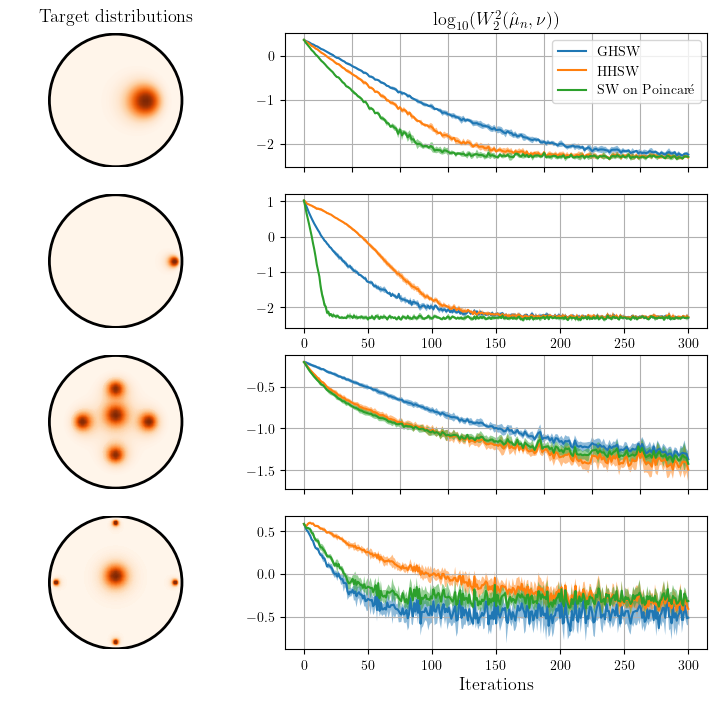

In [30]:
import matplotlib.font_manager

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": "cm"
})

fig, ax = plt.subplots(4, 2, figsize=(9,8), gridspec_kw={"width_ratios":[1,2]})

plot_fig(X_target_wnd_c, L_ghsw_wnd_c, L_hhsw_wnd_c, L_sw_wnd_c, L_hhswp_wnd_c, ax[0,0], ax[0,1], 
         xticks=False, xlabels=False, title=True,legend=True, ax0_legend=True, alpha=0.5)
plot_fig(X_target_wnd_b, L_ghsw_wnd_b, L_hhsw_wnd_b, L_sw_wnd_b, L_hhswp_wnd_b, ax[1,0], ax[1,1], h=5, alpha=0.5)
plot_fig(X_target_mwnd_c, L_ghsw_mwnd_c, L_hhsw_mwnd_c, L_sw_mwnd_c, L_hhswp_mwnd_c, ax[2,0], ax[2,1], 
         xticks=False, xlabels=False, title=False, alpha=0.5)
plot_fig(X_target_mwnd_b, L_ghsw_mwnd_b, L_hhswp_mwnd_b, L_sw_mwnd_b, L_hhswp_mwnd_b, ax[3,0], ax[3,1], 
         h=0.15, alpha=0.5)

# plt.savefig("./Comparison_Evolution_HSWFs_vertical_LateX.pdf", format="pdf", bbox_inches="tight")

plt.show()